# Credit Score Classification

**Problem Statement:** You are working as a data scientist in a global finance company. Over the years, the company has collected basic bank details and gathered a lot of credit-related information. The management wants to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts.

**Task:** Given a person’s credit-related information, build a machine learning model that can classify the credit score. There are three possible classes: ```Good```, ```Standard``` and ```Poor```.


Data from https://www.kaggle.com/datasets/parisrohan/credit-score-classification

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost  import XGBClassifier

from sklearn.metrics import (confusion_matrix, accuracy_score, balanced_accuracy_score,
                            precision_score, recall_score, f1_score, cohen_kappa_score, 
                            classification_report, make_scorer)

## 2. Data Cleaning

In [3]:
train_data = pd.read_csv('data/train.csv', low_memory=False)

In [4]:
train_data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
train_data.shape

(100000, 28)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [7]:
# We can remove some columns: ID, Name, SSN (social security number)
train_data.drop(columns=['ID', 'Name', 'SSN'], inplace=True)

### 2.1 Numeric Variables

* Some numeric variables ends with ```_```
* Some of then has values ```__10000_``` and ```__-333333333333333333333333333_```.They were considered NaN

In [8]:
# Some attributes should be numeric, but some values end with '_':
# 'Age', 'Annual_Income' ,'Num_of_Loan', 'Num_of_Delayed_Payment', 
# 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance'

numeric_values = pd.to_numeric(train_data['Annual_Income'], errors='coerce')
train_data['Annual_Income'][numeric_values.isna()]

10        34847.84_
27        30689.89_
32        35547.71_
56        34081.38_
66       114838.41_
            ...    
99959     38321.39_
99974     16680.35_
99981      37188.1_
99993     39628.99_
99999     39628.99_
Name: Annual_Income, Length: 6980, dtype: object

In [9]:
# Replacing '_' with '' at the end of the values.
numeric_columns = ['Age', 'Annual_Income' ,'Num_of_Loan', 'Num_of_Delayed_Payment', 
                   'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

train_data[numeric_columns] = train_data[numeric_columns].replace('_$', '', regex=True)

In [10]:
train_data.replace('', np.nan, inplace=True)

In [11]:
# Some values have "__10000_" or "__-333333333333333333333333333_" entry, they were considered NaN
train_data[numeric_columns] = train_data[numeric_columns].replace('__10000_|__-333333333333333333333333333_', np.nan, regex=True)

In [12]:
int_columns = ['Age','Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
               'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date']
float_columns = ['Annual_Income', 'Changed_Credit_Limit', 'Outstanding_Debt',
                 'Amount_invested_monthly', 'Monthly_Balance']          

train_data[int_columns]= train_data[int_columns].astype('Int64')
train_data[float_columns] = train_data[float_columns].astype('float64')

In [13]:
# Some columns can't have negative values, they are set to NaN
non_negative = ['Age', 'Annual_Income' ,'Num_of_Loan', 'Num_of_Delayed_Payment',
                'Num_Bank_Accounts', 'Num_Credit_Card', 'Monthly_Inhand_Salary',
                'Interest_Rate', 'Num_Credit_Inquiries', 'Outstanding_Debt', 
                'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly',
                'Monthly_Balance']

def replace_neg_with_nan(value):
    if value < 0:
        return np.nan
    return value
    
train_data[non_negative] = train_data[non_negative].map(replace_neg_with_nan)

In [14]:
train_data[int_columns]= train_data[int_columns].astype('Int64')

### 2.2 Categorical Variables

* 'Occupation' and 'Credit_Mix': replace ```_``` with Nan
* 'Payment_of_Min_Amount': replace ```NM``` with Nan
* 'Credit_History_Age': convert **str** format from ```X years and Y months``` to **int** ```X*12+Y months```
* Column 'Type_of_Loan' converted to one column per type.
* Column 'Payment_Behaviour' which is in str format: ```X_spent_Y_value_payments``` turns into two columns: ```Spent_Amount``` and ```Value_Payments_Size```

In [15]:
train_data['Occupation'].unique()

array(['Scientist', '_______', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [16]:
train_data['Credit_Mix'].unique()

array(['_', 'Good', 'Standard', 'Bad'], dtype=object)

In [17]:
# Replacing "__" categories with NaN
train_data[['Occupation', 'Credit_Mix']] = train_data[['Occupation', 'Credit_Mix']].replace('_{1,}', np.nan, regex=True)

In [18]:
train_data['Payment_of_Min_Amount'].unique()

array(['No', 'NM', 'Yes'], dtype=object)

In [19]:
# Replacing "NM" category with NaN
train_data['Payment_of_Min_Amount'] = train_data['Payment_of_Min_Amount'].replace('NM', np.nan)

In [20]:
train_data['Credit_History_Age'].unique()[:10]

array(['22 Years and 1 Months', nan, '22 Years and 3 Months',
       '22 Years and 4 Months', '22 Years and 5 Months',
       '22 Years and 6 Months', '22 Years and 7 Months',
       '26 Years and 7 Months', '26 Years and 8 Months',
       '26 Years and 9 Months'], dtype=object)

In [21]:
# Converting 'Credit_History_Age' to # of Months on a new Column 'Credit_History_Age_Months'
years_and_months = train_data['Credit_History_Age'].str.extract(r'(\d+) Years and (\d+) Months')
years_and_months = years_and_months.astype('Int64')
months = years_and_months[0]*12 + years_and_months[1]

train_data['Credit_History_Age_Months'] = months

# 'Credit_History_Age' column can be deleted now
train_data.drop('Credit_History_Age', axis=1, inplace=True)

In [22]:
train_data['Type_of_Loan'].unique()

array(['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'Auto Loan, Auto Loan, and Not Specified',
       ..., 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan',
       'Payday Loan, Student Loan, Mortgage Loan, and Not Specified',
       'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan'],
      dtype=object)

In [23]:
# Each loan type becomes a column
train_data['Type_of_Loan'] = train_data['Type_of_Loan'].replace('and ', '', regex=True)

loan_types = train_data['Type_of_Loan'].str.split(', ').explode().tolist()
loan_types = list(set(loan_types))
loan_types

['Debt Consolidation Loan',
 'Personal Loan',
 'Home Equity Loan',
 'Credit-Builder Loan',
 'Not Specified',
 'Auto Loan',
 nan,
 'Mortgage Loan',
 'Student Loan',
 'Payday Loan']

In [24]:
# The new column names follow the pattern: "<Type>_Loan" or "Not_Specified"
loan_types = [s for s in loan_types if isinstance(s, str)]
column_names = [re.sub(r' |-', '_', s) for s in loan_types]

for l_type in loan_types:
    column_name = re.sub(r' |-', '_', l_type)
    train_data[column_name] = train_data['Type_of_Loan'].str.count(l_type)

train_data[column_names] = train_data[column_names].astype('Int64')

In [25]:
# When number of loan = 0, all loan types has its counts equal to 0
train_data.loc[train_data['Num_of_Loan'] == 0, column_names] = 0

In [26]:
# Column 'Type_of_Loan can be deleted'
train_data.drop('Type_of_Loan', axis=1, inplace=True)

In [27]:
train_data['Payment_Behaviour'].unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments', '!@9#%8',
       'High_spent_Large_value_payments'], dtype=object)

In [28]:
train_data['Payment_Behaviour'] = train_data['Payment_Behaviour'].replace('!@9#%8', np.nan)

In [29]:
# Creating two new columns for Spent Amount and value payments size
spent_and_payments = train_data['Payment_Behaviour'].str.extract(r'(\w+)_spent_(\w+)_value_payments')
train_data['Spent_Amount'] = spent_and_payments[0]
train_data['Value_Payments_Size'] = spent_and_payments[1]

train_data.drop('Payment_Behaviour', axis=1, inplace=True)

In [30]:
train_data['Credit_Score'].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

### 2.3. Handling Null values

Now we can predict the NaN values based on the other values of the same customers (Grouped by ```Customer_ID```)

* Float columns are replaced with the mean of a customers values
* Int columns are replaced with the mode of values
* Categorical columns are replaced with the most repeated category

In [31]:
float_columns = [col for col in train_data.columns if train_data[col].dtype == 'float64']
float_columns_means = train_data.groupby('Customer_ID')[float_columns].transform('mean')

train_data[float_columns] = train_data[float_columns].fillna(float_columns_means)

In [32]:
int_columns = [col for col in train_data.columns if train_data[col].dtype == 'Int64']
int_columns_mode = train_data.groupby('Customer_ID')[int_columns].transform(lambda x: x.mode()[0])

train_data[int_columns] = train_data[int_columns].fillna(int_columns_mode)

In [33]:
object_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']
object_columns_mode = train_data.groupby('Customer_ID')[object_columns].transform(lambda x: 
                                                                                  x.mode()[0] if not x.mode().empty 
                                                                                  else None)

train_data[object_columns] = train_data[object_columns].fillna(object_columns_mode)

In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Customer_ID                100000 non-null  object 
 1   Month                      100000 non-null  object 
 2   Age                        100000 non-null  Int64  
 3   Occupation                 93280 non-null   object 
 4   Annual_Income              100000 non-null  float64
 5   Monthly_Inhand_Salary      100000 non-null  float64
 6   Num_Bank_Accounts          100000 non-null  Int64  
 7   Num_Credit_Card            100000 non-null  Int64  
 8   Interest_Rate              100000 non-null  Int64  
 9   Num_of_Loan                100000 non-null  Int64  
 10  Delay_from_due_date        100000 non-null  Int64  
 11  Num_of_Delayed_Payment     100000 non-null  Int64  
 12  Changed_Credit_Limit       100000 non-null  float64
 13  Num_Credit_Inquiries       100

## 3. Exploratory Data Analysis (EDA)

In [35]:
df = train_data.copy()

In [36]:
df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_History_Age_Months,Debt_Consolidation_Loan,Personal_Loan,Home_Equity_Loan,Credit_Builder_Loan,Not_Specified,Auto_Loan,Mortgage_Loan,Student_Loan,Payday_Loan
count,100000.0,1.000000e+05,100000.000000,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.000000,...,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,115.37331,1.764157e+05,4198.468568,17.09149,22.47443,72.46604,7.02288,21.06878,29.70323,10.388537,...,220.91127,0.38776,0.38888,0.39104,0.4044,0.39616,0.37992,0.38936,0.38968,0.40568
std,683.856594,1.429618e+06,3187.369878,117.404803,129.05741,466.422621,59.140535,14.860104,218.025389,6.784097,...,99.682053,0.645079,0.645644,0.646879,0.667462,0.650924,0.640176,0.642497,0.64998,0.66428
min,14.0,7.005930e+03,303.645417,0.0,0.0,1.0,0.0,-5.0,0.0,-6.490000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,25.0,1.945750e+04,1626.594167,3.0,4.0,8.0,2.0,10.0,9.0,5.340000,...,144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,33.0,3.757861e+04,3096.378333,6.0,5.0,13.0,3.0,18.0,14.0,9.400000,...,219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,42.0,7.279092e+04,5961.637500,7.0,7.0,20.0,5.0,28.0,18.0,14.850000,...,302.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,8698.0,2.419806e+07,15204.633333,1798.0,1499.0,5797.0,1496.0,67.0,4397.0,36.970000,...,404.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0


### 3.1. Continuous Variables

The next plot shows weird outliers on some variables: 'Annual_Income', 'Total_EMI_per_month'.

* They were replaced based on the other values for the same Customer_ID

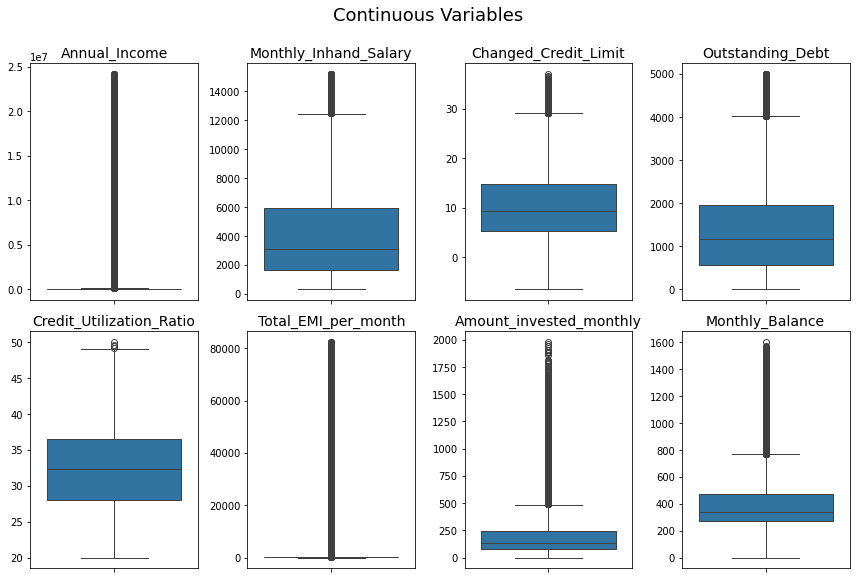

In [37]:
fig, axes = plt.subplots(2, 4, figsize=(12,8))

row = 0
col = 0

for column in float_columns:
    axes[row][col].set(ylabel=None)
    sns.boxplot(data=df, y=column, ax=axes[row][col]).set_title(column, fontsize=14)
    col += 1
    if col == 4:
        row += 1
        col = 0

fig.suptitle('Continuous Variables', fontsize=18, y=1)
plt.setp(axes, ylabel=None)
plt.tight_layout()
plt.show()

In [38]:
outlier_columns = ['Annual_Income', 'Total_EMI_per_month']

Q1 = train_data[outlier_columns].quantile(0.25)
Q3 = train_data[outlier_columns].quantile(0.75)
upper_limit = Q3 + 1.5*(Q3-Q1)

def replace_outliers_with_median(group, col_name):
    mask = group > upper_limit[col_name]
    group[mask] = group.mode()[0]
    return group   

for col in outlier_columns:
    df[col] = df.groupby('Customer_ID')[col].transform(replace_outliers_with_median, col_name=col)

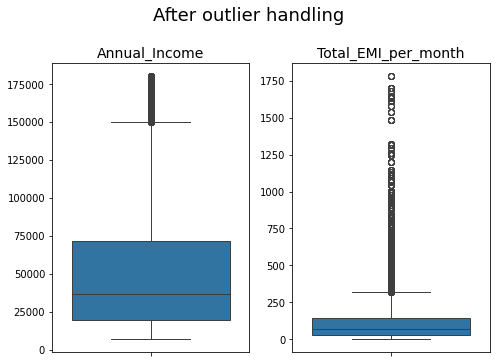

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(7,5))

row = 0

for column in outlier_columns:
    axes[row].set(ylabel=None)
    sns.boxplot(data=df, y=column, ax=axes[row]).set_title(column, fontsize=14)
    row += 1

fig.suptitle('After outlier handling', fontsize=18, y=1)
plt.setp(axes, ylabel=None)
plt.tight_layout()
plt.show()

### 3.2. Integer Variables

The next plot shows weird outliers on some variables: 'Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_Credit_Inquires'.

* They were replaced based on the other values for the same Customer_ID

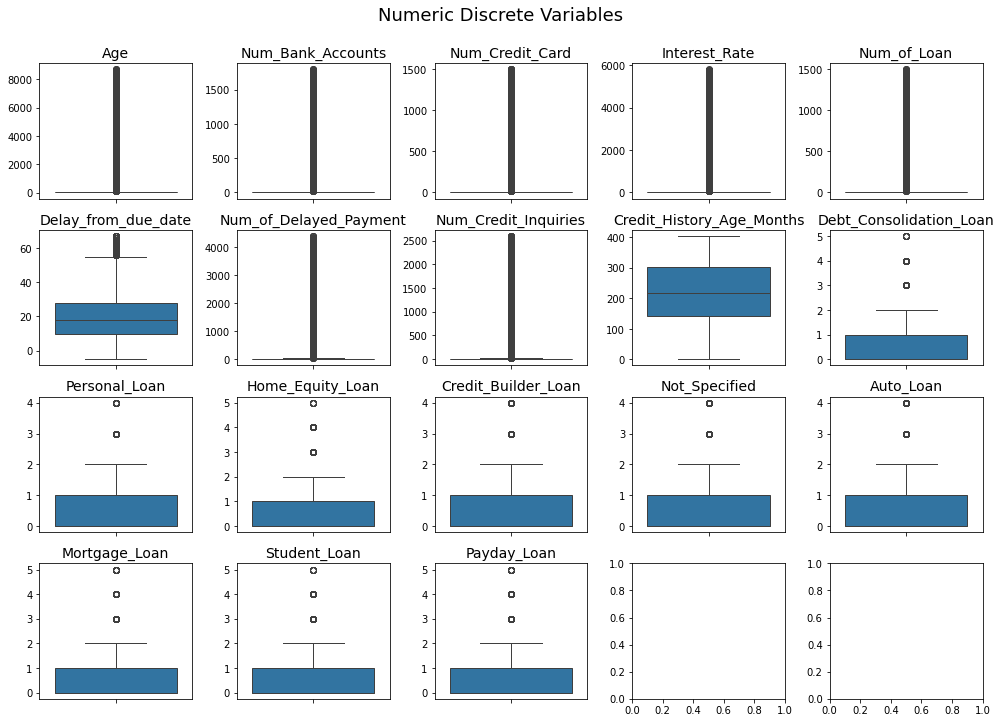

In [40]:
fig, axes = plt.subplots(4, 5, figsize=(14,10))

row = 0
col = 0

for column in int_columns:
    axes[row][col].set(ylabel=None)
    sns.boxplot(data=df, y=column, ax=axes[row][col]).set_title(column, fontsize=14)
    col += 1
    if col == 5:
        row += 1
        col = 0

fig.suptitle('Numeric Discrete Variables', fontsize=18, y=1)
plt.setp(axes, ylabel=None)
plt.tight_layout()
plt.show()

In [41]:
outlier_columns = ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 
                    'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment', 
                    'Num_Credit_Inquiries']

Q1 = train_data[outlier_columns].quantile(0.25)
Q3 = train_data[outlier_columns].quantile(0.75)
upper_limit = Q3 + 1.5*(Q3-Q1) 

def replace_outliers_with_median(group, col_name):
    mask = group > upper_limit[col_name]
    group[mask] = group.mode()[0]
    return group 

for col in outlier_columns:
    df[col] = df.groupby('Customer_ID')[col].transform(replace_outliers_with_median, col_name=col)

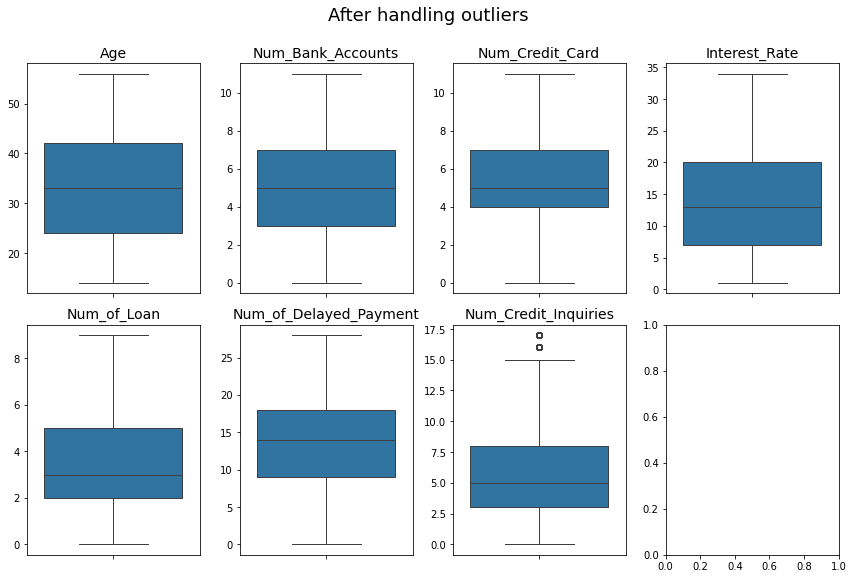

In [42]:
fig, axes = plt.subplots(2, 4, figsize=(12,8))

row = 0
col = 0

for column in outlier_columns:
    axes[row][col].set(ylabel=None)
    sns.boxplot(data=df, y=column, ax=axes[row][col]).set_title(column, fontsize=14)
    col += 1
    if col == 4:
        row += 1
        col = 0

fig.suptitle('After handling outliers', fontsize=18, y=1)
plt.setp(axes, ylabel=None)
plt.tight_layout()
plt.show()

### 3.3. Credit Score classes

* Some attributes seens not to change on different credit score classes, such as ```Credit_Utilization_Ratio```, ```Amount_Invested_Monthly```, ```Total_EMI_per_month``` and ```Loan Types```. They may not be considered for model's training.
* ```Spent_Amount``` and ```Value_Payment_Size``` don't look to have huge influence on credit score
* Through correlation matrix, we can verify that ```Anual_Income``` and ```Monthly_Inhand_Salary``` are redundant information, so one of them can be deleted.

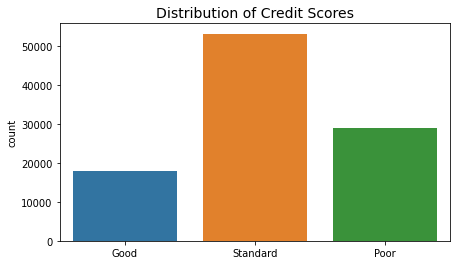

In [43]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='Credit_Score', hue='Credit_Score')
plt.title('Distribution of Credit Scores', fontsize=14)
plt.xlabel(None)
plt.show()

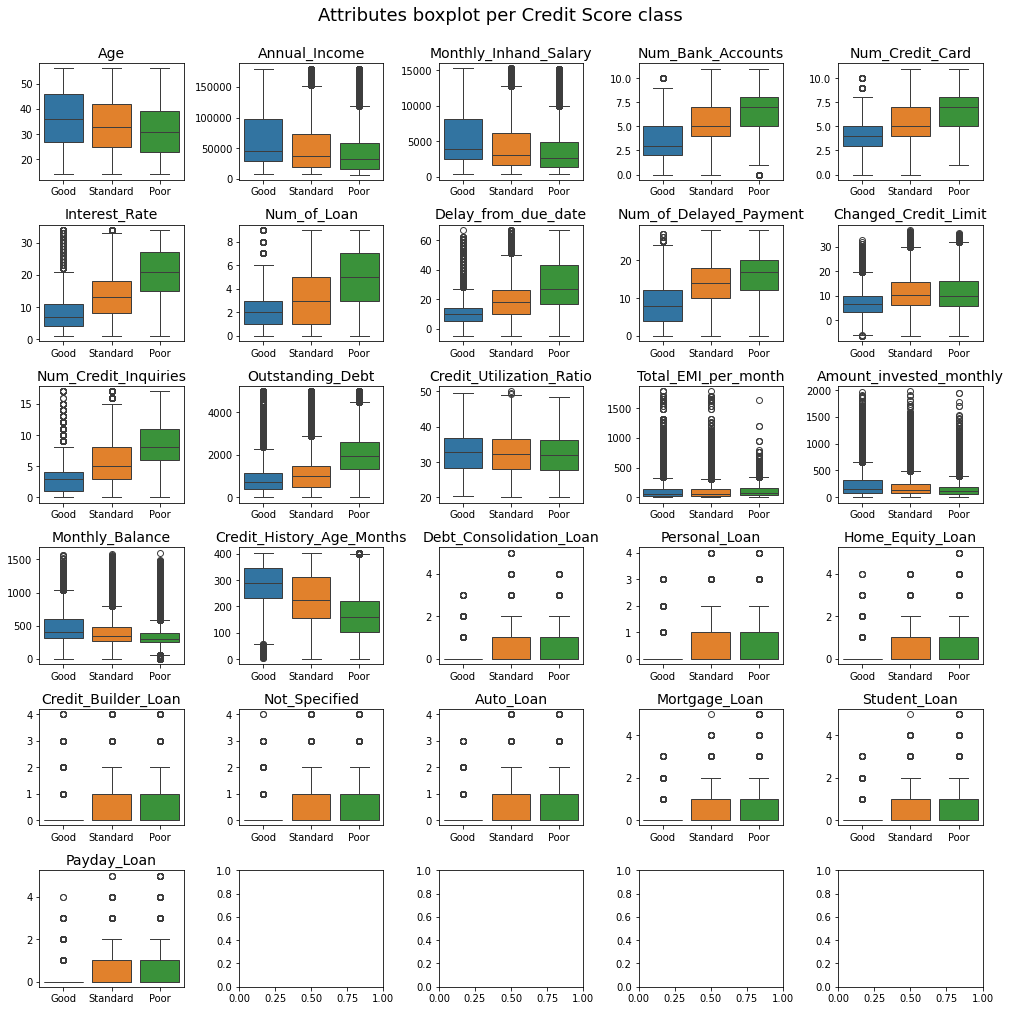

In [44]:
numeric_columns = df.select_dtypes(include=['float64', 'Int64']).columns

fig, axes = plt.subplots(6, 5, figsize=(14,14))

row = 0
col = 0

for column in numeric_columns:
    axes[row][col].set(ylabel=None)
    sns.boxplot(data=df, x='Credit_Score', y=column, 
                hue='Credit_Score', 
                ax=axes[row][col]).set_title(column, fontsize=14)
    col += 1
    if col == 5:
        row += 1
        col = 0
        
fig.suptitle('Attributes boxplot per Credit Score class', fontsize=18, y=1)
plt.setp(axes, ylabel=None, xlabel=None)
plt.tight_layout()
plt.show()

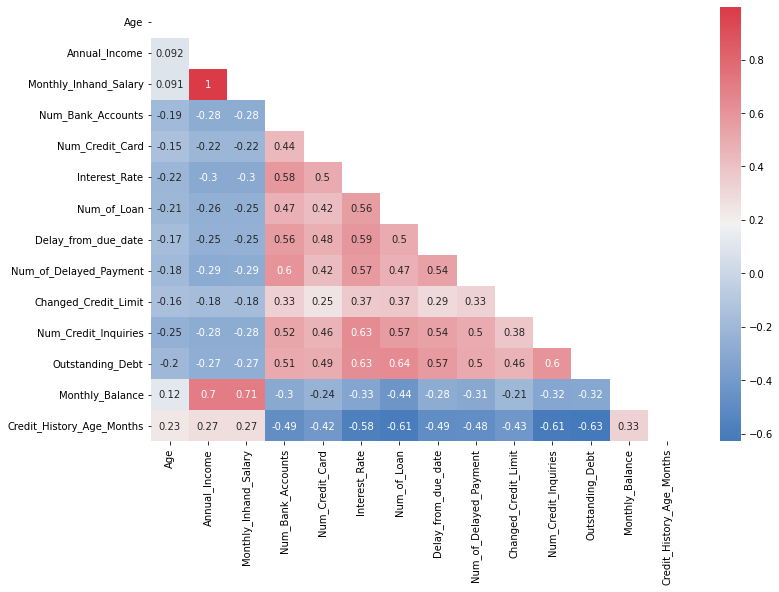

In [45]:
irrelevant_features = ['Payday_Loan', 'Debt_Consolidation_Loan',
                        'Not_Specified', 'Credit_Builder_Loan', 'Mortgage_Loan', 'Auto_Loan',
                        'Home_Equity_Loan', 'Student_Loan', 'Personal_Loan', 'Credit_Utilization_Ratio',
                        'Total_EMI_per_month', 'Amount_invested_monthly']
numeric_columns = [col for col in numeric_columns if col not in irrelevant_features] 

plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(df[numeric_columns].corr(), dtype=bool))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap=cmap, mask=mask)
plt.show()

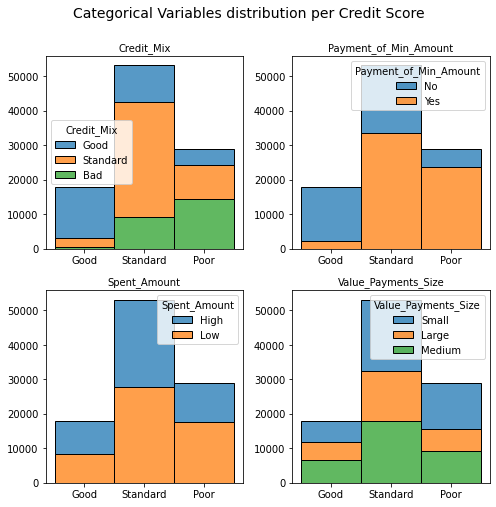

In [46]:
categorical_columns = ['Credit_Mix', 'Payment_of_Min_Amount', 'Spent_Amount', 'Value_Payments_Size']

fig, axes = plt.subplots(2, 2, figsize=(7,7))

row = 0
col = 0

for column in categorical_columns:
    #axes[row][col].set(ylabel=None)
    sns.histplot(data=df,ax=axes[row][col], x='Credit_Score', 
                 hue=column, multiple='stack').set_title(column, fontsize=10)
    col += 1
    if col == 2:
        row += 1
        col = 0
        
fig.suptitle('Categorical Variables distribution per Credit Score', fontsize=14, y=1)
plt.setp(axes, ylabel=None, xlabel=None)
plt.tight_layout()
plt.show()

## 4. Data Preparation

* Spliting into train and test sets
* One-Hot Encoding
* Rescaling (MinMax)

In [47]:
irrelevant_features = ['Payday_Loan', 'Debt_Consolidation_Loan',
                        'Not_Specified', 'Credit_Builder_Loan', 'Mortgage_Loan', 'Auto_Loan',
                        'Home_Equity_Loan', 'Student_Loan', 'Personal_Loan', 'Credit_Utilization_Ratio',
                        'Total_EMI_per_month', 'Amount_invested_monthly', 'Annual_Income',
                        'Customer_ID', 'Month', 'Occupation','Spent_Amount','Value_Payments_Size']

relevant_features = [col for col in df.columns if col not in irrelevant_features]
relevant_features

['Age',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_Mix',
 'Outstanding_Debt',
 'Payment_of_Min_Amount',
 'Monthly_Balance',
 'Credit_Score',
 'Credit_History_Age_Months']

In [48]:
train_df = df[relevant_features]

In [49]:
X = train_df[[col for col in train_df.columns if col != 'Credit_Score']]
y = train_df['Credit_Score']


categorical_columns = X.select_dtypes(object).columns
X = pd.concat( [X, pd.get_dummies(X[categorical_columns], dtype='int64')], axis=1)
X.drop(columns=categorical_columns, inplace=True)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=11)

In [51]:
MM = MinMaxScaler()

X_train[X.columns] = MM.fit_transform(X_train[X.columns])
X_test[X.columns] = MM.transform(X_test[X.columns])

## 5. Feature Selection

* All 18 features will be considered

In [52]:
X_train.shape

(70000, 18)

In [53]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

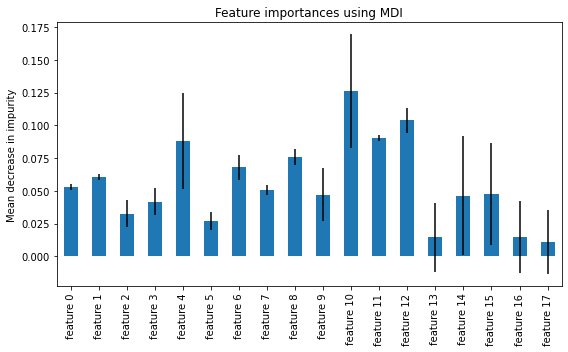

In [54]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(8,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 5. Machine Learning Models

In [79]:
# Returns classification metrics
def get_metrics(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0.0)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3)}, 
                        index=[model_name])

### 5.1. Dummy Model (Baseline)

In [86]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

In [87]:
print(classification_report(y_test, y_pred, zero_division=0.0))

              precision    recall  f1-score   support

        Good       0.00      0.00      0.00      5349
        Poor       0.00      0.00      0.00      8699
    Standard       0.53      1.00      0.69     15952

    accuracy                           0.53     30000
   macro avg       0.18      0.33      0.23     30000
weighted avg       0.28      0.53      0.37     30000



In [88]:
dummy_scores = get_metrics('Dummy', y_test, y_pred)
dummy_scores

,Balanced Accuracy,Precision,Recall,F1
Dummy,0.333,0.177,0.333,0.231


### 5.2. Random Forest Classifier

In [89]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(X_train, y_train)

y_pred = RFC.predict(X_test)

In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.77      0.77      0.77      5349
        Poor       0.79      0.83      0.81      8699
    Standard       0.83      0.81      0.82     15952

    accuracy                           0.81     30000
   macro avg       0.80      0.80      0.80     30000
weighted avg       0.81      0.81      0.81     30000



In [91]:
random_forest_scores = get_metrics('Random Forest', y_test, y_pred)
random_forest_scores

,Balanced Accuracy,Precision,Recall,F1
Random Forest,0.804,0.799,0.804,0.801


### 5.3. Multinomial Logistic Regression

In [98]:
MLR = LogisticRegression(random_state=0, multi_class='multinomial', max_iter=1000)
MLR.fit(X_train, y_train)

y_pred = MLR.predict(X_test)

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.55      0.71      0.62      5349
        Poor       0.67      0.55      0.60      8699
    Standard       0.71      0.71      0.71     15952

    accuracy                           0.66     30000
   macro avg       0.64      0.66      0.64     30000
weighted avg       0.67      0.66      0.66     30000



In [99]:
multi_logistic_regression = get_metrics('Multinomial Logistic Regression', y_test, y_pred)
multi_logistic_regression

,Balanced Accuracy,Precision,Recall,F1
Multinomial Logistic Regression,0.656,0.643,0.656,0.644


### 5.4. XGBoost

In [106]:
y_trainXGB = y_train.map({"Poor": 0, "Standard": 1, "Good": 2})
y_testXGB = y_test.map({"Poor": 0, "Standard": 1, "Good": 2})

In [110]:
XGB = XGBClassifier()
XGB.fit(X_train, y_trainXGB)

y_pred = XGB.predict(X_test)

In [111]:
print(classification_report(y_testXGB, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      8699
           1       0.79      0.78      0.79     15952
           2       0.70      0.73      0.71      5349

    accuracy                           0.77     30000
   macro avg       0.75      0.76      0.75     30000
weighted avg       0.77      0.77      0.77     30000



In [112]:
XGBoost = get_metrics('XGBoost', y_testXGB, y_pred)
XGBoost

,Balanced Accuracy,Precision,Recall,F1
XGBoost,0.757,0.751,0.757,0.754


## 6. Model Comparison

* Random Forest model had the best performance overall (F1 score = 0.801). It will be chosen for hyperparemeter tuning.

In [115]:
all_models = pd.concat([dummy_scores, random_forest_scores, 
                        multi_logistic_regression, XGBoost]).sort_values(by='F1', ascending=False)
all_models

,Balanced Accuracy,Precision,Recall,F1
Random Forest,0.804,0.799,0.804,0.801
XGBoost,0.757,0.751,0.757,0.754
Multinomial Logistic Regression,0.656,0.643,0.656,0.644
Dummy,0.333,0.177,0.333,0.231


## 7. Hyperparameter Tuning

* Tuning hyperparameters for Random Forest Classifier
    * Number of trees (n_estimators)
    * Maximum depth of tree (max_depth)
    * The minimum number of samples required to be at a leaf node (min_samples_leaf)
    * The minimum number of samples required to split an internal node (min_samples_split)
   

In [182]:
n_estimators = [30, 50, 100]
max_depth = [10, 20, 50, 100]
min_samples_leaf = [1, 2, 3]
min_samples_split = [2, 4]

In [183]:
params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split
}

In [184]:
RFModel = RandomForestClassifier()

In [185]:
RFGrid = GridSearchCV(estimator=RFModel,
                      param_grid=params,
                      cv=3,
                      verbose=3,
                      n_jobs=-1)

In [186]:
RFGrid.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 50, 100],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [30, 50, 100]},
             verbose=3)

In [187]:
best_params = RFGrid.best_params_
best_params

{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

In [188]:
RFGrid.best_score_

0.7937571695072753

### 7.1. Best Parameters

In [189]:
RF_GridS = RandomForestClassifier(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators']
)

RF_GridS.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_split=4)

In [190]:
y_pred = RF_GridS.predict(X_test)

In [191]:
results = get_metrics('Random Forest GS', y_test, y_pred)
results

,Balanced Accuracy,Precision,Recall,F1
Random Forest GS,0.804,0.8,0.804,0.801
